# Get At-Risk Customers Using Business Metrics

In [1]:
import os
from datetime import datetime
from pathlib import Path

import boto3
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from IPython.display import Markdown

In [2]:
PROJ_ROOT = Path.cwd().parent

In [3]:
assert load_dotenv(dotenv_path=PROJ_ROOT.parent / '.env')

In [4]:
import r2.io_utils as r2io
import cc_churn.costs as costs
import cc_churn.visualization as vzu

## About

Get the at-risk customers and determine how many customers should be selected in order to maximize true ROI while minimizing error in predicted ROI.

## User Inputs

In [5]:
# best model name
best_model_name = 'histgradientboostingclassifier'

# R2 data bucket details
bucket_name = 'cc-churn-splits'

# columns to load
columns = [
    'clientnum',
    'card_category',
    'total_revolv_bal',
    'total_trans_amt',
    'model_name',
    'y_pred_proba',
    'y_pred',
    'best_decision_threshold',
    'is_churned',
]

# costs
# # revenue from transactions (bank earns #% of transaction volume)
interchange_rate = 0.02
# # revenue from revolving balance (~20% interest)
apr = 0.18
# # fee revenue from credit card exposure (modeled from card type)
card_fees = {"Blue": 0, "Silver": 50, "Gold": 100, "Platinum": 200}
tenure_years = 3
discount = 0.9
# # percentage of churners who can be convinced to stay (i.e. success rate
# # of saving a churning customer)
success_rate = 0.40
# # cost of intervention to get a single customer to not churn (discounts,
# # call center time, retention offers, etc.)
intervention_cost = 50
# # cost of acquiring a new customer (Customer Acquisition Cost, CAC)
replacement_cost = 200
# # maximum number of customers that can be targeted based on client's budget
num_customers_max = 200

In [6]:
account_id = os.getenv('ACCOUNT_ID')
access_key_id = os.getenv('ACCESS_KEY_ID')
secret_access_key = os.getenv('SECRET_ACCESS_KEY')

# R2 data bucket details
# # name of validation data with predictions key (file) in private R2 bucket
r2_key_val_partial = f'validation_predictions__{best_model_name}__'
# # name of test data with predictions key (file) in private R2 bucket
r2_key_test_partial = f'test_predictions__{best_model_name}__'

s3_client = boto3.client(
    's3',
    endpoint_url=f'https://{account_id}.r2.cloudflarestorage.com',
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    region_name='auto'
)

# costs
multiplier = (1 - discount**tenure_years) / (1 - discount)

## Load Data with Predictions

Load validation data with predictions

In [ ]:
%%time
df_val_pred = r2io.pandas_read_filtered_parquets_r2(
    s3_client, bucket_name, r2_key_val_partial, columns
)
print(f"Got {len(df_val_pred):,} rows of validation split predictions")
with pd.option_context('display.max_columns', None):
    display(df_val_pred)

Load test data with predictions

In [ ]:
%%time
df_test_pred = r2io.pandas_read_filtered_parquets_r2(
    s3_client, bucket_name, r2_key_test_partial, columns
)
print(f"Got {len(df_test_pred):,} rows of test split predictions")
with pd.option_context('display.max_columns', None):
    display(df_test_pred)

Extract best decision threshold from model predictions of the validation data

In [10]:
best_decision_threshold = df_val_pred['best_decision_threshold'].head(1).squeeze()

Extract name of best ML model from model predictions of the validation data

In [11]:
best_model_name = df_val_pred['model_name'].head(1).squeeze()

## Model Validation

### Costs

Calculate the true savings, expected (predicted) savings and error in predicted savings (cost) using the validation data

In [ ]:
%%time
df_costs_val, _, _ = costs.get_cost(
    df_val_pred,
    best_decision_threshold,
    interchange_rate,
    apr,
    card_fees,
    multiplier,
    success_rate,
    intervention_cost,
)
with pd.option_context('display.max_columns', None):
    display(df_costs_val)

**Notes**

1. The following columns are related to the business costs and are discussed in the [project scoping document](https://github.com/edesz/credit-card-churn/blob/main/references/01_proposal.md)
   - `interchange_rev`
   - `interest_rev`
   - `fee_rev`
   - `annual_rev`
   - `clv`
   - `success_rate`
   - `expected_savings`
   - `true_savings`
   - `cum_pred_savings`
   - `cum_true_savings`
   - `n`
   - `total_intervention_cost`
   - `ROI`
   - `ROI_pred`
   - `ROI_error`
   - `ROI_percent`
   - `ROI_percent_pred`
2. The costs are only calculated for customers that are predicted to churn since these are the customers that will be targeted. For this reason, there are fewer rows in the costs `DataFrame` (`df_costs_val`) than in the `DataFrame` with the ML model predictions for the validation data (`df_val_pred`).
3. ROI is a business-focused Key Performance Indicator (KPI). It provides a broader view of the financial efficiency of an entire investment, considering both costs and gains. So, the KPI that should be reported to the client is the expected (predicted) ROI.

### Get Optimal Number of Targeted Customers (`N`)

Plot true and predicted expected savings and ROI curves to visualize the following

1. true ROI
2. predicted ROI

using the validation data

CPU times: user 21.7 ms, sys: 4.92 ms, total: 26.6 ms
Wall time: 26.1 ms


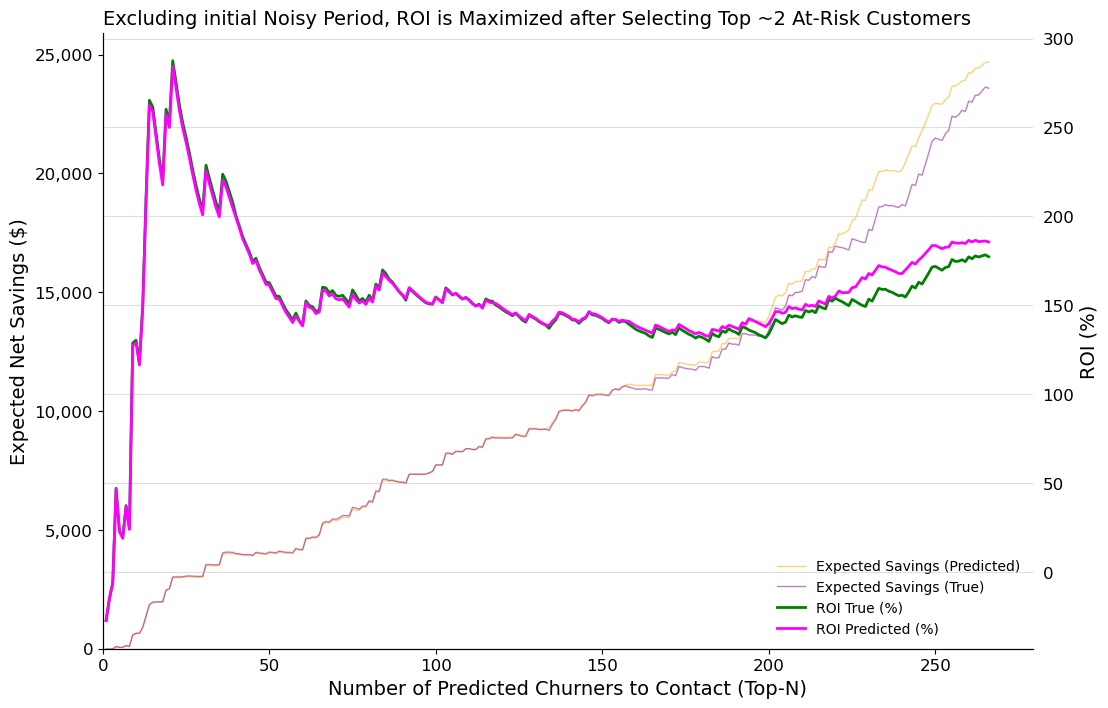

In [13]:
%%time
vzu.plot_roi_curves(
    df_costs_val['n'],
    df_costs_val['cum_true_savings'],
    df_costs_val['cum_pred_savings'],
    df_costs_val['ROI_percent'],
    df_costs_val['ROI_percent_pred'],
    {},
    ptitle=(
        'Excluding initial Noisy Period, ROI is Maximized after Selecting Top '
        '~2 At-Risk Customers'
    ),
    legend_loc='lower right',
    xlabel=f"Number of Predicted Churners to Contact (Top-N)",
    ylabel="Expected Net Savings ($)",
    fig_size=(12, 8),
)

**Notes**

1. The model cost is the error in predicted ROI.

Below are selected components involved in the calculation of ROI to explore the source of the initial noisy period in the ROI from the above chart

In [14]:
cols_table = [
    'n',
    'y_pred_proba',
    'total_revolv_bal',
    'interchange_rev',
    'interest_rev',
    'fee_rev',
    'expected_savings',
    'ROI_percent',
]
with pd.option_context('display.max_rows', None):
    display(
        df_costs_val[cols_table]
        .head(25)
        .style
        .set_properties(
            subset=[
                'total_revolv_bal',
                'interchange_rev',
                'interest_rev',
                'expected_savings',
                'ROI_percent',
            ],
            **{'background-color': 'yellow', 'color': 'black'}
        )
    )

,n,y_pred_proba,total_revolv_bal,interchange_rev,interest_rev,fee_rev,expected_savings,ROI_percent
0,1,0.996680,0.000000,33.680000,0.000000,0,-13.612101,-26.981760
1,2,0.996567,168.000000,14.820000,30.240000,0,-1.322621,-14.645840
2,3,0.995973,0.000000,51.540000,0.000000,0,5.644395,-5.850987
3,4,0.994995,502.000000,50.960000,90.360000,0,102.424188,47.207200
4,5,0.994775,0.000000,13.080000,0.000000,0,-35.895362,23.437248
5,6,0.994647,0.000000,46.320000,0.000000,0,-0.057894,19.601333
6,7,0.994377,464.000000,29.480000,83.520000,0,71.803176,37.513143
7,8,0.994140,0.000000,15.980000,0.000000,0,-32.779180,24.654580
8,9,0.992696,2517.000000,37.220000,453.060000,0,477.581676,128.907076
9,10,0.992139,214.000000,24.020000,38.520000,50,71.034415,130.415040


**Observations**

1. High fluctuations are caused by customers with a high `total_revolv_bal`. These customers generate higher `interest_rev` for the client than other customers. The `interest_rev` term dominates the calculation of ROI, which is not the case for other customers. As a result, ROI fluctuates strongly when these customers are included. Selecting as many **high `total_revolv_bal`** customers as possible captures steep increases in ROI.
2. `fee_rev` is fixed based on the `card_category` column. So, the interest revenue can dominate the overall ROI if the customer has a high revolving balance.

**Observations from the chart**

1. Due to the accuracy of the best ML model, the true and predicted ROI curves are close to each other. As a result, the optimal number can be safely determined in order to maximize true ROI, without needing to emphasize minimizing error in predicted ROI.
2. There are customers with a high `total_revolv_bal` in the top 90 customers. This results in the maximum possible ROI. Between ~90 and ~200, the influence of these customers is minimal so strong fluctuations are not observed. Between ~200 and ~265, the high `total_revolv_bal` customers appear again and ROI shows an upward trend from ~140% to ~175%.
3. Depending on the client's available budget, there are two possible scenarios
   - if the budget allows for targeting at most the top 100 customers then the optimal number of customers is ~90 since it captures all the high `total_revolv_bal` customers in this range (0-100).
   - if there is room in the budget to target all possible at-risk cutomers then the optimal number of customers is ~85 or ~270, since this captures the second ROI increase resulting in a ROI peak at ~265 customers

   Here, we will assume the latter is true. So, the optimal number customers to be targeted is ~265.

Find the optimal number of customers to target in order to minimize error in predicted ROI and maximize true ROI, using the costs on the validation data

In [15]:
%%time
df_costs_optimal = (
    df_costs_val
    .query(
        "(total_intervention_cost > 0) & "
        # capture second peak in ROI
        "(n >= 200)"
    )
    .sort_values(
        by=['ROI', 'ROI_error', 'n'], ascending=[False, True, True],
        ignore_index=True,
    )
    .head(1)
)
optimal_N_roi = df_costs_optimal['n'].squeeze()
cols_costs = [
    'n',
    'cum_true_savings',
    'cum_pred_savings',
    'ROI_error',
    'ROI_percent',
    'ROI_percent_pred',
]
(
    df_costs_optimal[cols_costs]
    .style
    .set_properties(
        subset=['ROI_error', 'ROI_percent_pred'],
        **{'background-color': 'yellow', 'color': 'black'}
    )
)

CPU times: user 8.35 ms, sys: 914 μs, total: 9.26 ms
Wall time: 8.93 ms


,n,cum_true_savings,cum_pred_savings,ROI_error,ROI_percent,ROI_percent_pred
0,265,23639.148720,24669.067460,-4.356835,178.408670,186.181641


In [16]:
roi_error_optimal_val = df_costs_optimal['ROI_error'].squeeze()
predicted_roi_optimal_val = df_costs_optimal['ROI_percent_pred'].squeeze()
Markdown(
    "**Observations**\n"
    "1. In order to maximize true ROI and minimize the error in predicted "
    f"ROI, the optimal number of customers to target is {optimal_N_roi}. "
    "This is consistent with observations from the chart above.\n"
    f"2. If the top {optimal_N_roi} customers from the test data are "
    "targeted, then the\n"
    "   - error in the predicted ROI is approximately "
    f"{roi_error_optimal_val:.1f}%\n"
    f"   - predicted ROI is approximately {predicted_roi_optimal_val:.1f}%"
)

**Observations**
1. In order to maximize true ROI and minimize the error in predicted ROI, the optimal number of customers to target is 265. This is consistent with observations from the chart above.
2. If the top 265 customers from the test data are targeted, then the
   - error in the predicted ROI is approximately -4.4%
   - predicted ROI is approximately 186.2%

## Model Evaluation

### Costs

Calculate the true savings, expected (predicted) savings and error in predicted savings (cost) using the test data

In [ ]:
%%time
df_costs_test, _, _ = costs.get_cost(
    df_test_pred,
    best_decision_threshold,
    interchange_rate,
    apr,
    card_fees,
    multiplier,
    success_rate,
    intervention_cost,
)
with pd.option_context('display.max_columns', None):
    display(df_costs_test)

**Notes**

1. The column names are identical to those in the costs calculated using the validation data (`df_costs_val`).

### Impact of Churn

The total impact of churn is estimated below for test data split

In [18]:
%%time
df_churn_impact_test = (
    df_costs_test
    .groupby('is_churned')
    .agg({'clv': ['sum', 'count']})
    .set_axis(['clv_total', 'num_customers'], axis=1)
    .reset_index()
    .assign(
        clv_fraction=lambda df: (
            (df['clv_total']/df['clv_total'].sum()).mul(100)
        ),
        clv_per_customer=lambda df: df['clv_total']/df['num_customers'],
    )
    .query("is_churned == True")
    .reset_index(drop=True)
    .assign(
        impact_per_customer=lambda df: df['clv_per_customer']+replacement_cost,
        impact_total=lambda df: (
            df['clv_total']+df['num_customers'].mul(replacement_cost)
        ),
    )
)
impact = df_churn_impact_test['impact_total'].squeeze()
impact_per_cust = df_churn_impact_test['impact_per_customer'].squeeze()
frac_clv_lost = df_churn_impact_test['clv_fraction'].squeeze()
clv_per_customer_lost = df_churn_impact_test['clv_per_customer'].squeeze()
df_churn_impact_test

CPU times: user 7.08 ms, sys: 0 ns, total: 7.08 ms
Wall time: 6.73 ms


,is_churned,clv_total,num_customers,clv_fraction,clv_per_customer,impact_per_customer,impact_total
0,1,97985.0364,247,83.366435,396.700552,596.700552,147385.0364


**Notes**

1. As per the assumption made in the scoping noteboo, the CAC is assumed to be $200.

In [19]:
Markdown(
    "**Observations**\n"
    f"1. Approximately {frac_clv_lost:.1f}% of customer lifetime value is "
    "lost due to the 16% over the past 12 months in the test data split. The "
    f"impact to the client is a loss of approximately "
    f"{clv_per_customer_lost:.1f} dollars of customer lifetime value (per "
    "customer). Accounting for the cost to CAC, the total loss is "
    f"{impact_per_cust:,.1f} dollars per customer, or {impact:,.1f} dollars "
    "overall, due to churn."
)

**Observations**
1. Approximately 83.4% of customer lifetime value is lost due to the 16% over the past 12 months in the test data split. The impact to the client is a loss of approximately 396.7 dollars of customer lifetime value (per customer). Accounting for the cost to CAC, the total loss is 596.7 dollars per customer, or 147,385.0 dollars overall, due to churn.

### Get Optimal Number of Targeted Customers (`N`)

Plot true and predicted expected savings and ROI curves to visualize the following

1. true ROI
2. predicted ROI
3. optimal number of customers determined using validation data

using the test data, and compare to the optimal number of customers based maximum true ROI and on error in predicted ROI using the test data

CPU times: user 19 ms, sys: 3 μs, total: 19.1 ms
Wall time: 18.9 ms


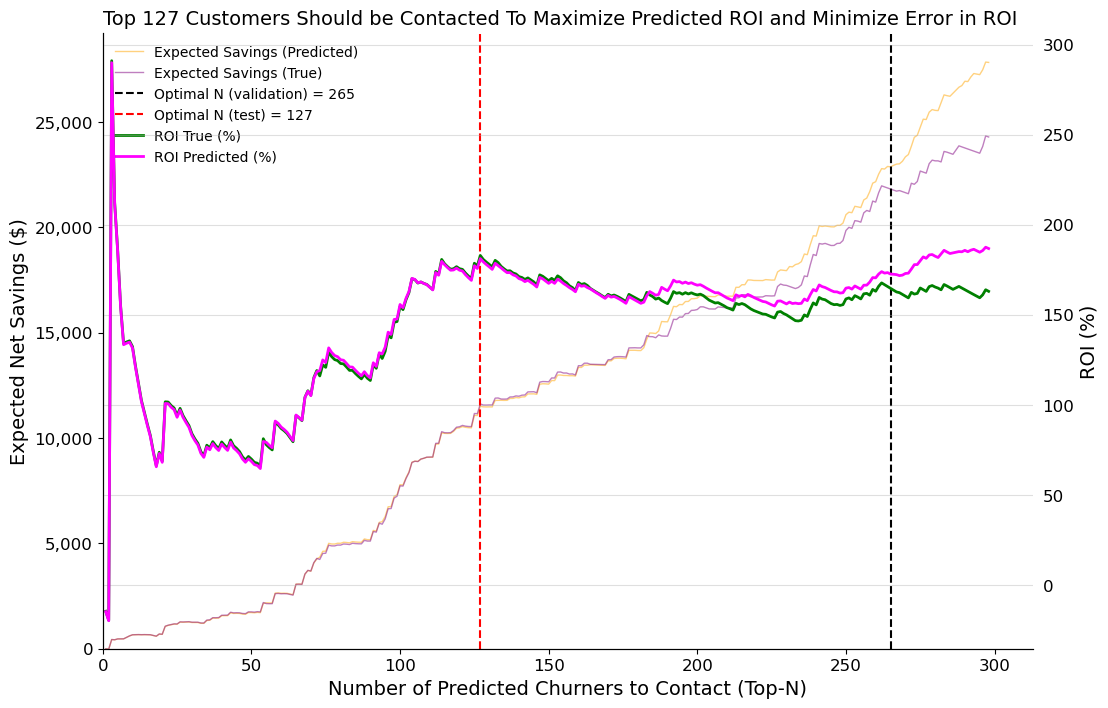

In [20]:
%%time
vzu.plot_roi_curves(
    df_costs_test['n'],
    df_costs_test['cum_true_savings'],
    df_costs_test['cum_pred_savings'],
    df_costs_test['ROI_percent'],
    df_costs_test['ROI_percent_pred'],
    {
        f'Optimal N (validation) = {optimal_N_roi}': {
            'x': optimal_N_roi, 'colour': 'black',
        },
        f'Optimal N (test) = {127}': {
            'x': 127, 'colour': 'red',
        },
    },
    ptitle=(
        f'Top {127:,} Customers Should be Contacted To Maximize '
        'Predicted ROI and Minimize Error in ROI'
    ),
    legend_loc='upper left',
    xlabel=f"Number of Predicted Churners to Contact (Top-N)",
    ylabel="Expected Net Savings ($)",
    fig_size=(12, 8),
)

**Observations**

1. It is again reassuring that the true and predicted ROI curves are close to each other. So, the optimal number of customers can be determined only based on maximizing the true ROI without needing to minimize error in predicted ROI.
2. This chart shows that 265 is not the optimal number of customers in order to maximize true ROI (green curve) for customers in the test (unseen) data. The optimal number of customers to target should be 127.

Find the optimal number of customers to target in order to maximize true ROI, using the costs from the test data

In [21]:
%%time
df_costs_optimal_test = (
    df_costs_test
    .query(
        "(total_intervention_cost > 0) & "
        # capture peak in ROI at approximately n=125
        "(n >= 100) & (n < 150)"
    )
    .sort_values(
        by=['ROI', 'ROI_error', 'n'], ascending=[False, True, True],
        ignore_index=True,
    )
    .head(1)
)
cols_costs = [
    'n',
    'cum_true_savings',
    'cum_pred_savings',
    'clv',
    'ROI_error',
    'ROI_percent',
    'ROI_percent_pred',
]
optimal_N_roi_test = df_costs_optimal_test['n'].squeeze()
(
    df_costs_optimal_test[cols_costs].assign(split='test')
    .style
    .set_properties(
        subset=['ROI_percent_pred'],
        **{'background-color': 'yellow', 'color': 'black'}
    )
)

CPU times: user 12.8 ms, sys: 988 μs, total: 13.8 ms
Wall time: 13.2 ms


,n,cum_true_savings,cum_pred_savings,clv,ROI_error,ROI_percent,ROI_percent_pred,split
0,127,11618.384000,11508.382007,1271.315200,0.946793,182.966677,181.234362,test


In [22]:
roi_error_optimal = df_costs_optimal_test['ROI_error'].squeeze()
true_roi_optimal = df_costs_optimal_test['ROI_percent'].squeeze()
predicted_roi_optimal = df_costs_optimal_test['ROI_percent_pred'].squeeze()
Markdown(
    "**Observations**\n"
    "1. In order to maximize true ROI and minimize the error in true "
    f"ROI, the optimal number of customers to target is {optimal_N_roi_test}.\n"
    f"2. If the top {optimal_N_roi_test} customers from the test data are "
    "targeted, then the\n"
    f"   - error in the predicted ROI is approximately {roi_error_optimal:.1f}%\n"
    f"   - true ROI is approximately {true_roi_optimal:.1f}%\n"
    f"   - predicted ROI is approximately {predicted_roi_optimal:.1f}%"
)

**Observations**
1. In order to maximize true ROI and minimize the error in true ROI, the optimal number of customers to target is 127.
2. If the top 127 customers from the test data are targeted, then the
   - error in the predicted ROI is approximately 0.9%
   - true ROI is approximately 183.0%
   - predicted ROI is approximately 181.2%

### Get Loss in Predicted ROI Using Optimized Number of Targeted Customers (`N`)

We must follow the recommendations from model validation that the top 265 *predicted* churners should be contacted. If we do this, then we can calculate the percent change in the KPI (*predicted* ROI) compared to this optimal value. This percent change is the *predicted* loss in ROI that will be incurred by the client by following the recommendations from the validation data

In [23]:
%%time
df_costs_test_best = (
    df_costs_test[['n', 'y_pred_proba', 'cum_pred_savings', 'ROI_percent_pred']]
    .query(f"(n == {optimal_N_roi}) | (n == {optimal_N_roi_test})")
    .sort_values(by=['n'], ascending=True, ignore_index=True)
    .assign(
        pct_pred_ROI_lost=lambda df: (
            100*df['ROI_percent_pred'].pct_change()
        ),
        source_for_n=lambda df: pd.Series(
            ['validation data', 'test data'], index=df.index
        )
    )
)
error_pred_roi = (
    df_costs_test_best
    .query("source_for_n == 'test data'")
    ['pct_pred_ROI_lost']
    .squeeze()
)
display(
    df_costs_test_best
    .style
    .set_properties(
        subset=['cum_pred_savings', 'ROI_percent_pred', 'pct_pred_ROI_lost'],
        **{'background-color': 'yellow', 'color': 'black'}
    )
)

,n,y_pred_proba,cum_pred_savings,ROI_percent_pred,pct_pred_ROI_lost,source_for_n
0,127,0.957974,11508.382007,181.234362,,validation data
1,265,0.820231,22874.685687,172.639137,-4.742602,test data


CPU times: user 7.84 ms, sys: 0 ns, total: 7.84 ms
Wall time: 7.8 ms


**Notes**

1. Calculations are performed using customers in the unseen (test) data split.

In [24]:
Markdown(
    "**Observations**\n"
    "1. If we apply the recommendations from model validation and contact "
    f"(target) the top {optimal_N_roi} customers in unseen data (test split), "
    "then the client is incorrectly reported a loss of approximately "
    f"{error_pred_roi:.2f}% of the maximum possible *predicted* ROI. "
    "This error is so small (less than 5%) due to the accuracy of the best "
    "model. This is reassuring. We will assume this is level of error is "
    "acceptable to the client. If there is no model and/or data drift in "
    "production, relative to the customers in the test data, then a similar "
    "error should be expected."
)

**Observations**
1. If we apply the recommendations from model validation and contact (target) the top 265 customers in unseen data (test split), then the client is incorrectly reported a loss of approximately -4.74% of the maximum possible *predicted* ROI. This error is so small (less than 5%) due to the accuracy of the best model. This is reassuring. We will assume this is level of error is acceptable to the client. If there is no model and/or data drift in production, relative to the customers in the test data, then a similar error should be expected.

Append column to costs indicating if targeting customer maximizes ROI

In [ ]:
df_costs_test = (
    df_costs_test
    .assign(maximizes_roi=lambda df: df['n'] <= optimal_N_roi)
)
(
    df_costs_test
    [
        [
            'clientnum',
            'n',
            'y_pred_proba',
            'y_pred',
            'clv',
            'ROI_percent_pred',
            'maximizes_roi',
        ]
    ]
)

### At-Risk Customers

In order to identify at-risk customers from the `y_pred_proba` (predicted probability) column, we must pick an optimal decision threshold based on the business goal (catching true churners). For the current business use-case, we need to prioritize recall. The optimal decision threshold was determined during ML development.

This decision threshold was optimized to maximize F2 Score, since it prioritizes recall over precision, which is in line with the business goal. The tuned threshold is stored in the `best_decision_threshold` column of `df_val_pred` and `df_test_pred`. The `y_pred` column was created by comparing `y_pred_proba` to the best decision threshold. With this in mind, the `y_pred` column already indicates if a customer is at-risk (1) or not (0).

So, the `y_pred` column will now be renamed to `is_at_risk`

In [ ]:
%%time
df_costs_test = df_costs_test.rename(columns={'y_pred': 'is_at_risk'})
with pd.option_context('display.max_columns', None):
    display(df_costs_test)

## Export Project Deliverables to Private R2 Bucket

Get the current timestamp in the format `YYmmdd_HHMMSS`

In [27]:
curr_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

### Unseen Data (Test Split) Customers with Indicator of At-Risk and Maximizing ROI

Combine costs (predicted churners) with predicted non-churners

In [ ]:
%%time
df_test_pred_with_costs = (
    pd.concat(
        [
            df_costs_test.assign(y_pred=1),
            df_test_pred.query("y_pred != 1"),
        ],
        ignore_index=True
    )
    .fillna(
        {
            'interchange_rev': np.nan,
            'interest_rev': np.nan,
            'fee_rev': np.nan,
            'annual_rev': np.nan,
            'clv': np.nan,
            'success_rate': np.nan,
            'expected_savings': np.nan,
            'true_savings': np.nan,
            'cum_pred_savings': np.nan,
            'cum_true_savings': np.nan,
            'n': np.nan,
            'random_savings': np.nan,
            'total_intervention_cost': np.nan,
            'ROI': np.nan,
            'ROI_pred': np.nan,
            'ROI_error': np.nan,
            'ROI_percent': np.nan,
            'ROI_percent_pred': np.nan,
            'maximizes_roi': np.nan,
            'is_at_risk': 0,
        }
    )
    .convert_dtypes(dtype_backend='pyarrow')
)
with pd.option_context('display.max_columns', None):
    display(df_test_pred_with_costs)

Next, export to a file in the R2 bucket with the following file name format `test_predictions_with_business_metrics__logisticregression__<current-timestamp-YYmmdd_HHMMSS>.parquet.gzip`

In [29]:
%%time
r2io.export_df_to_r2(
    s3_client=s3_client,
    df=df_test_pred_with_costs,
    bucket_name=bucket_name,
    r2_key=(
        f"test_predictions_with_business_metrics__{best_model_name.lower()}__"
        f"{curr_timestamp}.parquet.gzip"
    ),
)

Key test_predictions_with_business_metrics__histgradientboostingclassifier__20251014_213318.parquet.gzip does not exist in bucket cc-churn-splits
Exported 2,149 rows to key: test_predictions_with_business_metrics__histgradientboostingclassifier__20251014_213318.parquet.gzip
CPU times: user 27.6 ms, sys: 124 μs, total: 27.7 ms
Wall time: 298 ms
